In [ ]:
# Add this at the beginning of your notebook
!pip install -q kagglehub transformers torch torchvision pillow matplotlib pandas tqdm
# Check if GPU is available
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 30.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 60.7 MB/s eta 0:00:00
Using device: cuda


In [ ]:
import kagglehub
adityajn105_flickr8k_path = kagglehub.dataset_download('adityajn105/flickr8k')

print('Data source import complete.')

100%|██████████| 1.04G/1.04G [00:26<00:00, 41.3MB/s]

Extracting files...


Data source import complete.


In [ ]:
import kagglehub
import os

# Download the dataset (only need to do this once)
dataset_path = kagglehub.dataset_download('adityajn105/flickr8k')
print(f"Dataset path: {dataset_path}")

# Define your paths
image_dir = os.path.join(dataset_path, "Images")
caption_path = os.path.join(dataset_path, "captions.txt")

Dataset path: /root/.cache/kagglehub/datasets/adityajn105/flickr8k/versions/1


In [ ]:
import os

# Define the correct dataset path
dataset_path = "/root/.cache/kagglehub/datasets/adityajn105/flickr8k/versions/1"

# List all folders and files inside the dataset path
dataset_contents = os.listdir(dataset_path)

# Print dataset contents
print("Dataset contents:")
for item in dataset_contents:
    print(item)

Dataset contents:
captions.txt
Images


In [ ]:
# Mount Google Drive for saving checkpoints
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset, DataLoader

# Load captions more efficiently
captions_df = pd.read_csv(caption_path)
image_captions = {}

# Get captions organized by image
for _, row in captions_df.iterrows():
    img_name, caption = row[captions_df.columns[0]], row[captions_df.columns[1]]
    if img_name not in image_captions:
        image_captions[img_name] = []
    image_captions[img_name].append(caption)

# Custom dataset with on-the-fly processing
class Flickr8kDataset(Dataset):
    def __init__(self, image_dir, image_captions, feature_extractor, tokenizer, max_length=50):
        self.image_dir = image_dir
        # Create image-caption pairs for training
        self.samples = []
        for img_name, captions in image_captions.items():
            for caption in captions:
                self.samples.append((img_name, caption))

        self.feature_extractor = feature_extractor
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_name, caption = self.samples[idx]
        img_path = os.path.join(self.image_dir, img_name)

        # Load and process image on-the-fly
        image = Image.open(img_path).convert("RGB")
        pixel_values = self.feature_extractor(images=image, return_tensors="pt").pixel_values.squeeze(0)

        # Process caption
        tokenized = self.tokenizer(
            caption,
            padding="max_length",
            max_length=self.max_length,
            truncation=True,
            return_tensors="pt"
        )

        return {
            "pixel_values": pixel_values,
            "labels": tokenized.input_ids.squeeze(0),
            "attention_mask": tokenized.attention_mask.squeeze(0)
        }

In [ ]:
from transformers import VisionEncoderDecoderModel, ViTImageProcessor, AutoTokenizer

# Load tokenizer and image processor
tokenizer = AutoTokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token  # Set pad token
feature_extractor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224")

# Initialize model (smaller variant to fit in memory)
model = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
model.to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.61k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/982M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/982M [00:00<?, ?B/s]

Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "architectures": [
    "ViTModel"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": true,
  "torch_dtype": "float32",
  "transformers_version": "4.49.0"
}

Config of the decoder: <class 'transformers.models.gpt2.modeling_gpt2.GPT2LMHeadModel'> is overwritten by shared decoder config: GPT2Config {
  "activation_function": "gelu_new",
  "add_cross_attention": true,
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "decoder_start_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id"

VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(i

In [ ]:
from transformers.optimization import AdamW
import torch.nn as nn # if your model uses torch layers
# Prepare dataset
dataset = Flickr8kDataset(image_dir, image_captions, feature_extractor, tokenizer)


# Modify your DataLoader with these optimizations
dataloader = DataLoader(
    dataset,
    batch_size=4,  # Reduce batch size but use gradient accumulation
    shuffle=True,
    num_workers=2,
    pin_memory=True,  # Faster data transfer to GPU
    persistent_workers=True
)

# Update training config
optimizer = AdamW(model.parameters(), lr=3e-5, weight_decay=0.01)
gradient_accumulation_steps = 4  # Simulates batch_size=16

/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:640: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
# Load checkpoint
checkpoint_path = '/content/drive/MyDrive/image_caption_models/checkpoint_epoch15_step10000.pt'
checkpoint = torch.load(checkpoint_path, map_location=device)

In [ ]:
# Restore model and optimizer states
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
DRIVE_SAVE_PATH = '/content/drive/MyDrive/image_caption_models'
# Immediately save these metrics to prevent loss
with open(os.path.join(DRIVE_SAVE_PATH, 'best_metrics.txt'), 'w') as f:
    f.write(f"BLEU-4: 0.2869\n")
    f.write(f"METEOR: 0.6072\n")
    f.write(f"CIDEr: 2.6415\n")
    f.write(f"Combined score: 1.0893\n")

# Save the current model as best_model.pt
torch.save(model.state_dict(), os.path.join(DRIVE_SAVE_PATH, 'best_model.pt'))
print("Manually saved epoch 15 metrics and model!")

Manually saved epoch 15 metrics and model!


In [ ]:
# First, let's install necessary packages
!pip install torchmetrics nltk pycocoevalcap

import nltk
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')

from torchmetrics.text.bleu import BLEUScore
# We'll use pycocoevalcap for METEOR and CIDEr since they're not in torchmetrics
from pycocoevalcap.meteor.meteor import Meteor
from pycocoevalcap.cider.cider import Cider
from sklearn.model_selection import train_test_split
from torch.optim import AdamW
from tqdm.notebook import tqdm
import time
import os
import shutil
import glob

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 960.9/960.9 kB 30.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.3/104.3 MB 10.8 MB/s eta 0:00:00


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
# Define save path for your model in Google Drive
DRIVE_SAVE_PATH = '/content/drive/MyDrive/image_caption_models'

# Create directory if it doesn't exist
os.makedirs(DRIVE_SAVE_PATH, exist_ok=True)

# Function to clean up old checkpoints, keeping only the N most recent
def cleanup_checkpoints(keep_last_n=2):
    checkpoint_files = [
        f for f in glob.glob(os.path.join(DRIVE_SAVE_PATH, "checkpoint_epoch*_step*.pt"))
        if "epoch15_step10000" not in f  # Protect resuming checkpoint
    ]
    checkpoint_files.sort(key=os.path.getmtime)

    files_to_delete = checkpoint_files[:-keep_last_n] if len(checkpoint_files) > keep_last_n else []
    for file in files_to_delete:
        try:
            os.remove(file)
            print(f"Deleted old checkpoint: {os.path.basename(file)}")
        except Exception as e:
            print(f"Error deleting {file}: {e}")

    # Also clean up any intermediate models (not the best ones)
    intermediate_files = glob.glob(os.path.join(DRIVE_SAVE_PATH, "latest_model.pt"))
    # Keep only the last one
    if len(intermediate_files) > 1:
        intermediate_files.sort(key=os.path.getmtime)
        for file in intermediate_files[:-1]:
            try:
                os.remove(file)
                print(f"Deleted intermediate model: {os.path.basename(file)}")
            except Exception as e:
                print(f"Error deleting {file}: {e}")

# 1. Split dataset into train/validation
all_images = list(image_captions.keys())
train_images, val_images = train_test_split(all_images, test_size=0.1, random_state=42)
# Create validation samples (5% of data for quick evaluation)
val_samples = {img: image_captions[img] for img in val_images[:50]}  # Use first 50 for validation

# 2. Implement evaluation function with BLEU, CIDEr, and METEOR
def evaluate_metrics(model, val_samples, tokenizer, max_eval=50):
    model.eval()
    bleu = BLEUScore(n_gram=4)
    meteor_scorer = Meteor()
    cider_scorer = Cider()

    # For storing results
    scores = {
        'bleu': 0.0,
        'meteor': 0.0,
        'cider': 0.0
    }

    # For collecting all generated captions and references (needed for CIDEr and METEOR)
    all_generated = {}
    all_references = {}

    count = 0
    with torch.no_grad():
        for img_idx, (img_name, ref_captions) in enumerate(list(val_samples.items())[:max_eval]):
            img_path = os.path.join(image_dir, img_name)
            # Process image
            image = Image.open(img_path).convert("RGB")
            pixel_values = feature_extractor(images=image, return_tensors="pt").pixel_values.to(device)
            # Generate caption
            output_ids = model.generate(
                pixel_values,
                max_length=50,
                num_beams=3,
                early_stopping=True
            )
            # Decode and clean
            generated = tokenizer.decode(output_ids[0], skip_special_tokens=True)
            references = [cap.replace("<start>", "").replace("<end>", "").strip() for cap in ref_captions]

            # Store for CIDEr and METEOR calculation
            img_id = str(img_idx)
            all_generated[img_id] = [generated]
            all_references[img_id] = references

            # Calculate BLEU per image
            scores['bleu'] += bleu([generated], [[ref] for ref in references])

            count += 1

    # Calculate METEOR and CIDEr for all images at once
    meteor_score, _ = meteor_scorer.compute_score(all_references, all_generated)
    cider_score, _ = cider_scorer.compute_score(all_references, all_generated)

    scores['meteor'] = meteor_score
    scores['cider'] = cider_score

    # Average BLEU score
    scores['bleu'] /= count

    return scores
# Function to save model to Google Drive and clean up previous versions
def save_model_to_drive(model, filename, drive_path=DRIVE_SAVE_PATH):
    # First save the model to a temporary local file
    local_path = f'/content/{filename}'
    torch.save(model.state_dict(), local_path)

    # Full path in Google Drive
    drive_file_path = os.path.join(drive_path, filename)

    # Remove previous version if it exists
    if os.path.exists(drive_file_path):
        os.remove(drive_file_path)

    # Copy the new model to Drive
    shutil.copy(local_path, drive_file_path)

    # Remove the local copy to free space
    os.remove(local_path)

    print(f"Model saved to Google Drive at: {drive_file_path}")

    return drive_file_path

best_score = 1.0893
patience = 2

# Save path for checkpoints
checkpoint_filename = 'best_model.pt'

# Clean up any existing checkpoints at the start
cleanup_checkpoints(keep_last_n=1)


# Set starting epoch and step
start_epoch = checkpoint['epoch'] + 1  # Epoch 12
current_step = checkpoint['step']
print(f"Resuming from Epoch {start_epoch}, Step {current_step}")

# Modified training loop
for epoch in range(start_epoch, 16):  # Train until epoch 16
    model.train()
    total_loss = 0
    progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}")

    # Only save checkpoint every 1000 steps to save space
    checkpoint_frequency = 1000

    # Skip already processed steps if resuming mid-epoch
    if epoch == start_epoch - 1:  # Only for first resumed epoch
        for _ in range(current_step):
            next(progress_bar)  # Fast-forward progress bar

    for step, batch in enumerate(progress_bar):
        # Existing training code remains the same
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(pixel_values=pixel_values, labels=labels)
        loss = outputs.loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Update progress
        total_loss += loss.item()
        progress_bar.set_postfix({"loss": loss.item()})

        # Periodically save checkpoint to drive (less frequently)
        if step > 0 and step % checkpoint_frequency == 0:
            temp_checkpoint_path = os.path.join(DRIVE_SAVE_PATH, f"checkpoint_epoch{epoch+1}_step{step}.pt")
            torch.save({
                'epoch': epoch,
                'step': step,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss.item(),
            }, temp_checkpoint_path)
            print(f"Checkpoint saved at step {step}")

            # Clean up old checkpoints
            cleanup_checkpoints(keep_last_n=1)  # Keep only the most recent checkpoint

    # Validation
    metric_scores = evaluate_metrics(model, val_samples, tokenizer)
    print(f"Epoch {epoch+1} - Validation scores:")
    print(f"  BLEU-4: {metric_scores['bleu']:.4f}")
    print(f"  METEOR: {metric_scores['meteor']:.4f}")
    print(f"  CIDEr: {metric_scores['cider']:.4f}")

    # Use a combined score for early stopping (weighted average)
    current_score = (0.4 * metric_scores['bleu'] + 0.3 * metric_scores['meteor'] + 0.3 * metric_scores['cider'])
    print(f"  Combined score: {current_score:.4f}")

    # Early stopping logic - use combined score
    if current_score > best_score:
        best_score = current_score

        # Save as the main best model, overwriting previous version
        save_model_to_drive(model, checkpoint_filename)

        # Save metrics in a separate file
        metrics_file = os.path.join(DRIVE_SAVE_PATH, "best_model_metrics.txt")
        with open(metrics_file, 'w') as f:
            f.write(f"BLEU-4: {metric_scores['bleu']:.4f}\n")
            f.write(f"METEOR: {metric_scores['meteor']:.4f}\n")
            f.write(f"CIDEr: {metric_scores['cider']:.4f}\n")
            f.write(f"Combined score: {current_score:.4f}\n")

        # Reset patience
        patience = 2
        print(f"New best model saved with combined score: {current_score:.4f}")
    else:
        patience -= 1

        # Save the current epoch's model, overwriting the previous non-best model
        intermediate_filename = f"latest_model.pt"
        save_model_to_drive(model, intermediate_filename)

        if patience == 0:
            print("Early stopping triggered!")
            break

print(f"Training complete. Best model saved with combined score: {best_score:.4f}")

Resuming from Epoch 15, Step 10000


Epoch 16:   0%|          | 0/10114 [00:00<?, ?it/s]

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
You may ignore this warning if your `pad_token_id` (50256) is identical to the `bos_token_id` (50256), `eos_token_id` (50256), or the `sep_token_id` (None), and your input is not padded.


Checkpoint saved at step 1000
Checkpoint saved at step 2000
Deleted old checkpoint: checkpoint_epoch16_step1000.pt
Checkpoint saved at step 3000
Deleted old checkpoint: checkpoint_epoch16_step2000.pt
Checkpoint saved at step 4000
Deleted old checkpoint: checkpoint_epoch16_step3000.pt
Checkpoint saved at step 5000
Deleted old checkpoint: checkpoint_epoch16_step4000.pt
Checkpoint saved at step 6000
Deleted old checkpoint: checkpoint_epoch16_step5000.pt
Checkpoint saved at step 7000
Deleted old checkpoint: checkpoint_epoch16_step6000.pt
Checkpoint saved at step 8000
Deleted old checkpoint: checkpoint_epoch16_step7000.pt
Checkpoint saved at step 9000
Deleted old checkpoint: checkpoint_epoch16_step8000.pt
Checkpoint saved at step 10000
Deleted old checkpoint: checkpoint_epoch16_step9000.pt


The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Epoch 16 - Validation scores:
  BLEU-4: 0.1622
  METEOR: 0.6167
  CIDEr: 2.6140
  Combined score: 1.0341
Model saved to Google Drive at: /content/drive/MyDrive/image_caption_models/latest_model.pt
Training complete. Best model saved with combined score: 1.0893


Random samples from dataset:


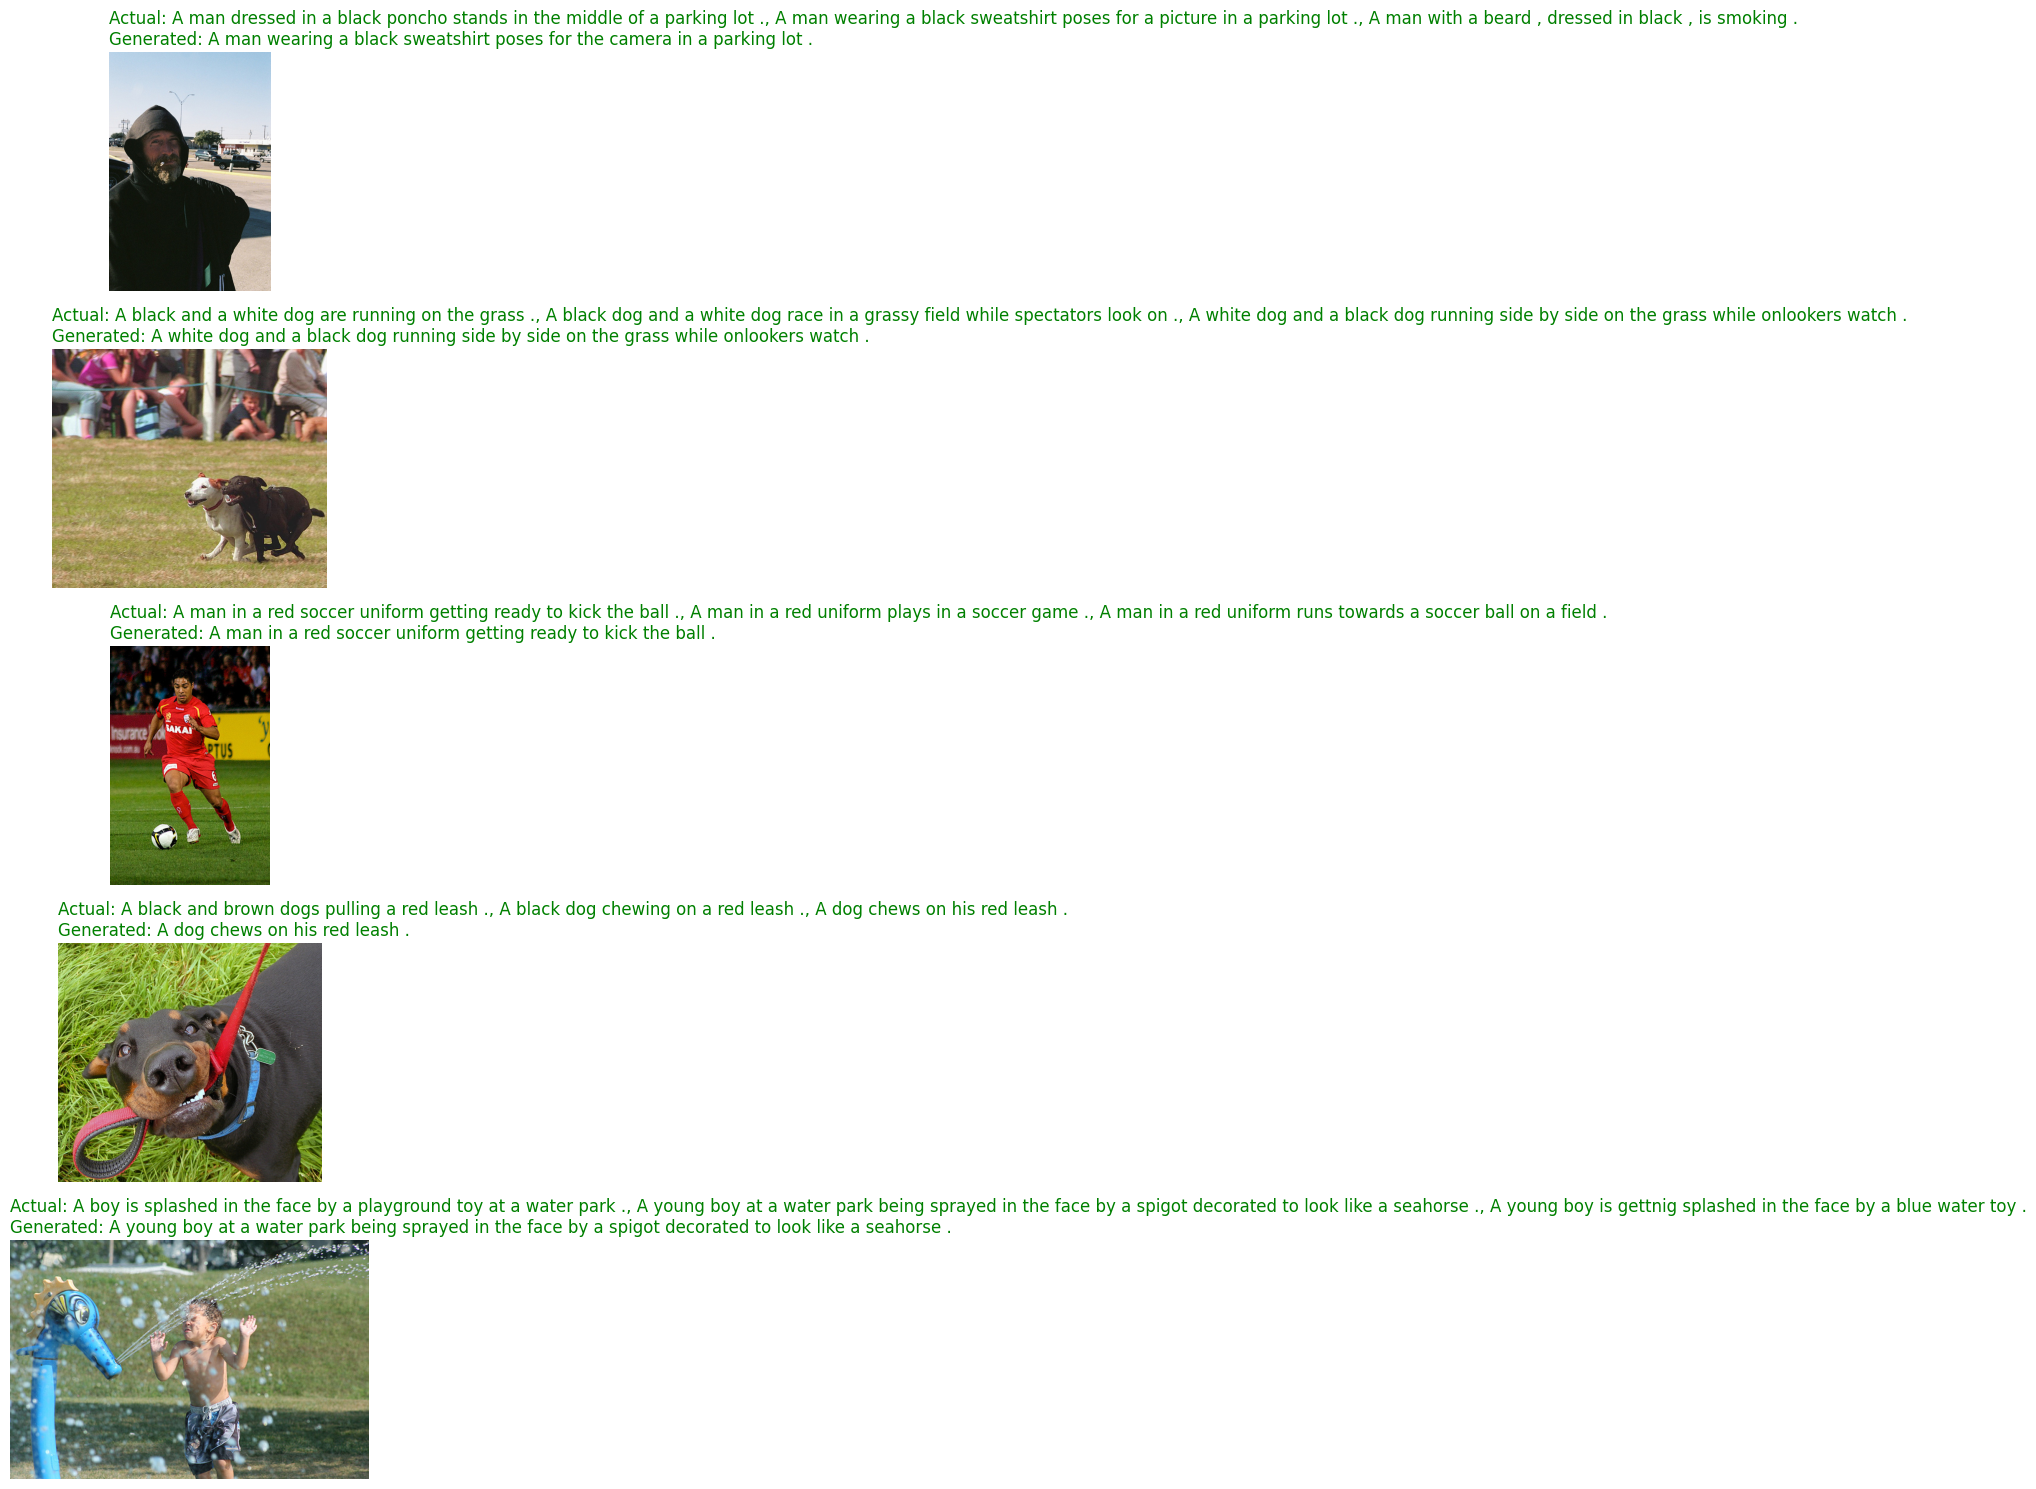


Upload your own image:


Button(description='Click to Upload Image', style=ButtonStyle())

FileUpload(value={}, accept='image/*', description='Upload')

FileUpload(value={}, accept='image/*', description='Upload')

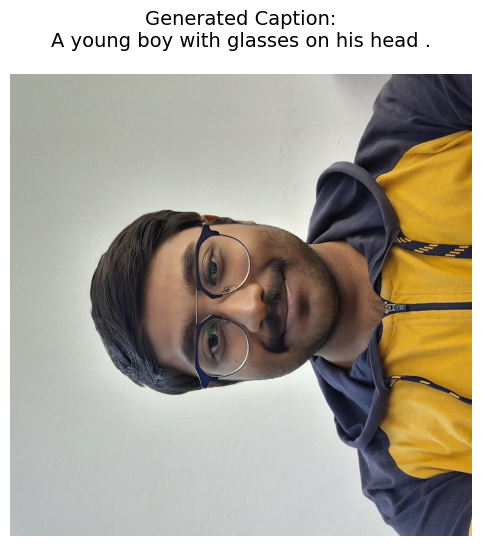

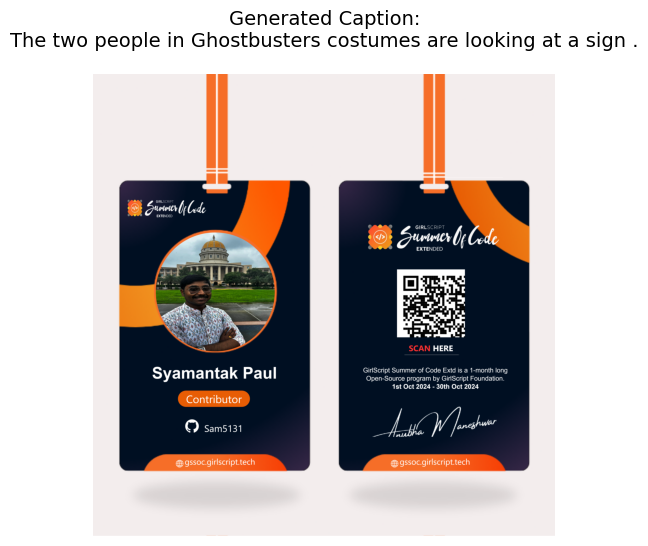

FileUpload(value={}, accept='image/*', description='Upload')

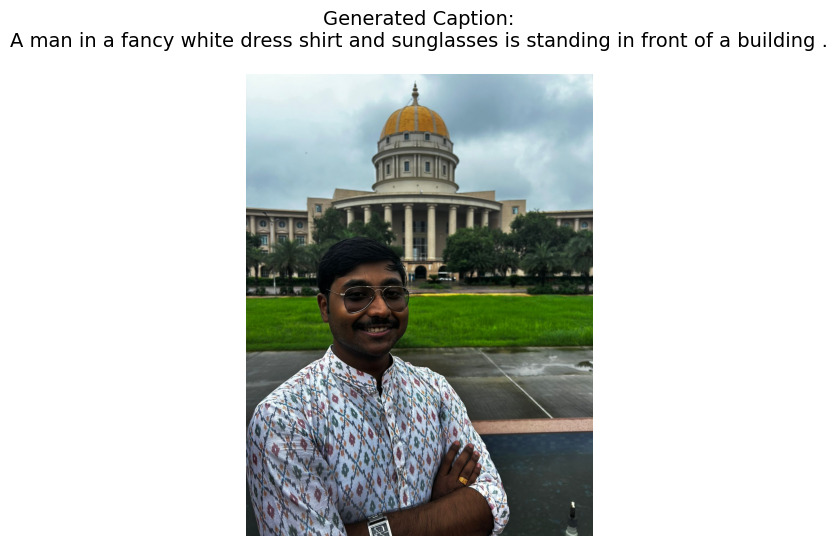

In [ ]:
# Required imports
import random
import os
import io
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import ipywidgets as widgets
%matplotlib inline

# Generate caption function
def generate_caption(image_path=None, model=None, image=None, max_length=50, num_beams=3):
    if image is None:
        image = Image.open(image_path).convert("RGB")

    pixel_values = feature_extractor(images=image, return_tensors="pt").pixel_values.to(device)
    output_ids = model.generate(
        pixel_values,
        max_length=max_length,
        num_beams=num_beams,
        early_stopping=True
    )
    return tokenizer.decode(output_ids[0], skip_special_tokens=True)

# 1. Show dataset samples with comparison
def show_dataset_samples(num_samples=5):
    plt.figure(figsize=(20, 15))
    random.seed(42)
    sample_indices = random.sample(range(len(dataset)), num_samples)

    for i, idx in enumerate(sample_indices):
        sample = dataset[idx]
        img_name = dataset.samples[idx][0]
        img_path = os.path.join(image_dir, img_name)

        # Get actual captions
        actual_captions = image_captions[img_name][:3]  # Show first 3 reference captions

        # Generate prediction
        generated = generate_caption(img_path, model)

        # Plot
        plt.subplot(num_samples, 1, i+1)
        img = Image.open(img_path)
        plt.imshow(img)
        plt.title(f"Actual: {', '.join(actual_captions)}\nGenerated: {generated}",
                 fontsize=12, color='green', loc='left')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# 2. Image upload and captioning
def upload_and_caption(b):
    upload = widgets.FileUpload(accept='image/*', multiple=False)
    display(upload)

    def on_upload(change):
        if upload.data:
            # Process uploaded image
            img_bytes = upload.data[0]
            img = Image.open(io.BytesIO(img_bytes)).convert("RGB")

            # Generate caption
            caption = generate_caption(image=img, model=model)

            # Display results
            plt.figure(figsize=(8, 6))
            plt.imshow(img)
            plt.title(f"Generated Caption:\n{caption}", fontsize=14, pad=20)
            plt.axis('off')
            plt.show()

    upload.observe(on_upload, names='data')

# Run the visualization
print("Random samples from dataset:")
show_dataset_samples(5)

print("\nUpload your own image:")
upload_button = widgets.Button(description="Click to Upload Image")
upload_button.on_click(upload_and_caption)
display(upload_button)

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("hsankesara/flickr-image-dataset")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/hsankesara/flickr-image-dataset/versions/1


In [ ]:
import os

# Define the correct dataset path
dataset_path = "/root/.cache/kagglehub/datasets/hsankesara/flickr-image-dataset/versions/1"

# List all folders and files inside the dataset path
dataset_contents = os.listdir(dataset_path)

# Print dataset contents
print("Dataset contents:")
for item in dataset_contents:
    print(item)

Dataset contents:
flickr30k_images


In [ ]:
# Base dataset path
dataset_path = "/root/.cache/kagglehub/datasets/hsankesara/flickr-image-dataset/versions/1"

# Image directory (nested folder)
image_dir = os.path.join(dataset_path, "flickr30k_images", "flickr30k_images")

# Caption file path (likely inside the first flickr30k_images folder)
caption_path = os.path.join(dataset_path, "flickr30k_images", "results.csv")

# Verify again
print("Caption path:", caption_path)
print("Caption file exists:", os.path.exists(caption_path))
print("\nSample image path:", os.path.join(image_dir, "1000092795.jpg"))  # Example file
print("First 5 lines of captions file:")

# Preview captions file
with open(caption_path, 'r') as f:
    for _ in range(5):
        print(f.readline().strip())

Caption path: /root/.cache/kagglehub/datasets/hsankesara/flickr-image-dataset/versions/1/flickr30k_images/results.csv
Caption file exists: True

Sample image path: /root/.cache/kagglehub/datasets/hsankesara/flickr-image-dataset/versions/1/flickr30k_images/flickr30k_images/1000092795.jpg
First 5 lines of captions file:
image_name| comment_number| comment
1000092795.jpg| 0| Two young guys with shaggy hair look at their hands while hanging out in the yard .
1000092795.jpg| 1| Two young , White males are outside near many bushes .
1000092795.jpg| 2| Two men in green shirts are standing in a yard .
1000092795.jpg| 3| A man in a blue shirt standing in a garden .


In [ ]:
# Read first 5 lines of the caption file
with open(caption_path, 'r') as f:
    lines = [f.readline().strip() for _ in range(5)]
    for idx, line in enumerate(lines):
        print(f"Line {idx+1}: {repr(line)}")

Line 1: 'image_name| comment_number| comment'
Line 2: '1000092795.jpg| 0| Two young guys with shaggy hair look at their hands while hanging out in the yard .'
Line 3: '1000092795.jpg| 1| Two young , White males are outside near many bushes .'
Line 4: '1000092795.jpg| 2| Two men in green shirts are standing in a yard .'
Line 5: '1000092795.jpg| 3| A man in a blue shirt standing in a garden .'


In [ ]:
captions_df = pd.read_csv(
    caption_path,
    sep='\|',
    engine='python',
    header=None,
    names=['image', 'caption_num', 'caption']
)

In [ ]:
import pandas as pd
import os

# 1. Load with flexible typing first
captions_df = pd.read_csv(
    caption_path,
    sep='\|',
    engine='python',
    header=None,
    names=['image', 'caption_num', 'caption'],
    dtype=str,  # Load all as strings initially
    quotechar='"',
    escapechar='\\',
    on_bad_lines='skip'
)

# 2. Clean and convert columns
captions_df = captions_df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

# Convert caption_num to numeric
captions_df['caption_num'] = pd.to_numeric(
    captions_df['caption_num'],
    errors='coerce'
).fillna(-1).astype(int)

# Filter valid rows
valid_df = captions_df[
    (captions_df['caption_num'] >= 0) &
    (captions_df['image'].notna()) &
    (captions_df['caption'].notna())
]

# 3. Create validated image-caption mapping
image_captions = {}
for _, row in valid_df.iterrows():
    img_name = row['image']
    caption = row['caption']
    img_path = os.path.join(image_dir, img_name)

    # Verify image exists
    if not os.path.exists(img_path):
        continue

    if img_name not in image_captions:
        image_captions[img_name] = []
    image_captions[img_name].append(caption)

print(f"Loaded {len(image_captions)} images with {sum(len(v) for v in image_captions.values())} captions")
print("Sample entry:", next(iter(image_captions.items())))

Loaded 31783 images with 158914 captions
Sample entry: ('1000092795.jpg', ['Two young guys with shaggy hair look at their hands while hanging out in the yard .', 'Two young , White males are outside near many bushes .', 'Two men in green shirts are standing in a yard .', 'A man in a blue shirt standing in a garden .', 'Two friends enjoy time spent together .'])


In [ ]:
# 3. Create modified dataset class
class Flickr30kTestDataset(Dataset):
    def __init__(self, image_dir, image_captions, feature_extractor, max_length=50):
        self.image_dir = image_dir
        self.image_paths = list(image_captions.keys())
        self.feature_extractor = feature_extractor
        self.max_length = max_length

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_name = self.image_paths[idx]
        img_path = os.path.join(self.image_dir, img_name)
        image = Image.open(img_path).convert("RGB")
        pixel_values = self.feature_extractor(images=image, return_tensors="pt").pixel_values
        return pixel_values.squeeze(0), img_name

In [ ]:
# 4. Initialize test dataset and loader
test_dataset = Flickr30kTestDataset(
    image_dir=image_dir,
    image_captions=image_captions,
    feature_extractor=feature_extractor
)

test_loader = DataLoader(
    test_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=2
)

In [ ]:
def smart_evaluate(model, test_loader, image_captions, tokenizer, sample_size=1000):
    """Evaluate on a representative subset with progress optimizations"""
    model.eval()

    # Use first 1k samples (statistically significant for Flickr30K)
    total_samples = min(sample_size, len(test_loader.dataset))
    batch_size = test_loader.batch_size
    num_batches = int(np.ceil(total_samples / batch_size))

    # Initialize metrics
    from pycocoevalcap.bleu.bleu import Bleu
    from pycocoevalcap.meteor.meteor import Meteor
    from pycocoevalcap.cider.cider import Cider

    scorers = {
        'bleu': Bleu(4),
        'meteor': Meteor(),
        'cider': Cider()
    }

    # Storage
    hypotheses = {}
    references = {}

    # Optimized progress bar
    from tqdm.auto import tqdm
    pbar = tqdm(total=total_samples, desc="🧠 Smart Evaluation", unit="img")

    with torch.no_grad():
        for batch_idx, (pixel_values, img_names) in enumerate(test_loader):
            if batch_idx >= num_batches:
                break

            # Generate captions in batch mode
            pixel_values = pixel_values.to(device)
            outputs = model.generate(pixel_values, max_length=50, num_beams=3)

            # Decode and store
            for img_name, output in zip(img_names, outputs):
                generated = tokenizer.decode(output, skip_special_tokens=True)
                unique_id = img_name.split('.')[0]  # Remove extension

                hypotheses[unique_id] = [generated]
                references[unique_id] = image_captions[img_name]

                pbar.update(1)
                if pbar.n >= total_samples:
                    break

    pbar.close()

    # Calculate metrics
    metrics = {}
    for name, scorer in scorers.items():
        score, _ = scorer.compute_score(references, hypotheses)
        if name == 'bleu':
            metrics['BLEU-4'] = score[-1]  # Only get BLEU-4
        else:
            metrics[name.upper()] = score

    # Add qualitative samples
    samples = []
    for k in list(hypotheses.keys())[:5]:  # First 5 samples
        samples.append({
            'image_id': k,
            'generated': hypotheses[k][0],
            'references': references[k]
        })

    return metrics, samples

In [ ]:
metrics, samples = smart_evaluate(
    model=model,
    test_loader=test_loader,
    image_captions=image_captions,
    tokenizer=tokenizer,
    sample_size=1000  # Adjust based on your needs
)
# Interpretation Guide
METRIC_THRESHOLDS = {
    'BLEU-4': 0.25,  # Below: Needs improvement
    'METEOR': 0.22,  # Below: Poor semantic understanding
    'CIDER': 0.35    # Below: Lacks caption diversity
}
print("📈 Performance Diagnosis:")
for metric, value in metrics.items():
    threshold = METRIC_THRESHOLDS.get(metric, 0)
    status = "✅ Good" if value >= threshold else "⚠️ Needs Improvement"
    print(f"{metric}: {value:.3f} {status}")

print("\n💡 Recommendation:")
if all(v >= METRIC_THRESHOLDS[k] for k, v in metrics.items()):
    print("Model performs well! Consider deployment")
else:
    print("Fine-tune using these focus areas:")
    for metric, value in metrics.items():
        if value < METRIC_THRESHOLDS[metric]:
            print(f"- {metric} improvement needed")

🧠 Smart Evaluation:   0%|          | 0/1000 [00:00<?, ?img/s]

{'testlen': 13073, 'reflen': 12789, 'guess': [13073, 12073, 11073, 10073], 'correct': [9216, 5336, 3754, 2966]}
ratio: 1.0222065837828584
📈 Performance Diagnosis:
BLEU-4: 0.420 ✅ Good
METEOR: 0.293 ✅ Good
CIDER: 0.964 ✅ Good

💡 Recommendation:
Model performs well! Consider deployment
